<a href="https://colab.research.google.com/github/dujest/yolov5-workshop/blob/main/Deep_CNN_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount your drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install the requirements

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
!mkdir /content/drive/MyDrive/colab

In [3]:
%cd /content/drive/MyDrive/colab

/content/drive/MyDrive/colab


# Download a dataset

In [ ]:
!mkdir "/content/drive/MyDrive/colab/corrosion_dataset"
!wget  "https://universe.roboflow.com/ds/LQgs4TYGAN?key=Q2icURdATO" -O "/content/drive/MyDrive/colab/corrosion_dataset/corrosion.zip"
!unzip "/content/drive/MyDrive/colab/corrosion_dataset/corrosion.zip" -d "/content/drive/MyDrive/colab/corrosion_dataset"
!rm -r "/content/drive/MyDrive/colab/corrosion_dataset/corrosion.zip"

# Load the train and test set

The next preprocessing and augmentations steps were applied:
- Auto-Orient: Applied
- Resize: Stretch to 416x416
- Outputs per training example: 3
- Flip: Horizontal, Vertical
- 90° Rotate: Clockwise, Counter-Clockwise, Upside Down
- Saturation: Between -15% and +15%
- Brightness: Between -12% and +12%
- Exposure: Between -5% and +5%
- Blur: Up to 0.5px

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(320), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.ImageFolder('/content/drive/MyDrive/colab/corrosion_dataset/train', transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.ImageFolder('/content/drive/MyDrive/colab/corrosion_dataset/valid', transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

classes = ("Corrosion", "No corrosion")

# Display function

In [5]:
%matplotlib inline

plt.rcParams["figure.figsize"] = (15, 50)

# displays unnormalized images
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [6]:
# fetchs a batch from the train set
dataiter = iter(trainloader)
images, labels = dataiter.next()

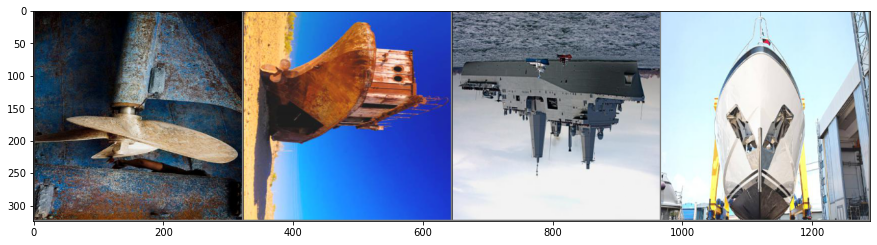

Corrosion 
Corrosion 
No corrosion
No corrosion


In [ ]:
imshow(torchvision.utils.make_grid(images))
print('\n'.join(f'{classes[labels[j]]:10s}' for j in range(batch_size)))

# The CNN model

In [7]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


Typical CNN architectures stack a few convolutional layers (each one generally followed by a ReLU layer), then a pooling layer, and so on.

The image gets smaller and smaller as it progresses through the network, but it also typically gets deeper and deeper (i.e., with more feature maps), thanks to the convolutional layers. At the top of the stack, a regular feedforward neural network is added, composed of a few fully connected layers (+ReLUs), and the final layer outputs the prediction.

In [ ]:
conv1 = nn.Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding='same').to(device)
pool = nn.MaxPool2d(2, 2).to(device)                                                   
conv2 = nn.Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding='same').to(device)
conv3 = nn.Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding='same').to(device)
conv4 = nn.Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False).to(device) # the bottleneck's start
bn1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True).to(device)
conv5 = nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding='same', bias=False).to(device)
conv6 = nn.Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), padding='same').to(device) 
bn2 = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True).to(device) # the bottleneck's end
conv7 = nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding='same').to(device)
fc1 = nn.Linear(512 * 20 * 20, 120).to(device) # fully connected
fc2 = nn.Linear(120, 84).to(device)
fc3 = nn.Linear(84, 2).to(device)

print(f'Before Conv1:\n {images[0][0]}')

print(f'\nThe image size:{images.shape}')

images = images.to(device)
print(f'\nThe image is sent to {images.device}')

x = conv1(images)
print(f'\nAfter Conv1 the image size is: {x.shape}')

x = pool(x)
print(f'\nAfter MaxPool the image size is: {x.shape}')

x = conv2(x)
print(f'\nAfter Conv2 the image size is: {x.shape}')

x = pool(x)
print(f'\nAfter MaxPool the image size is: {x.shape}')

x = conv3(x)
print(f'\nAfter Conv3 the image size is: {x.shape}')

x = pool(x)
print(f'\nAfter MaxPool the image size is: {x.shape}')

x = F.relu(bn1(conv4(x)))
print(f'\nAfter Conv4, BatchNorm and ReLU the image size is: {x.shape}')

x = F.relu(bn1(conv5(x)))
print(f'\nAfter Conv5, ReLU and BatchNorm the image size is: {x.shape}')

x = F.relu(bn2(conv6(x)))
print(f'\nAfter Conv6, ReLU and BatchNorm the image size is: {x.shape}')

x = conv7(x)
print(f'\nAfter Conv7 the image size is: {x.shape}')

x = pool(x)
print(f'\nAfter MaxPool the image size is: {x.shape}')

x = torch.flatten(x, 1)
print(f'\nAfter flatten the image size is: {x.shape}')

x = fc1(x)
print(f'\nAfter fc1 the image size is: {x.shape}')

x = fc2(x)
print(f'\nAfter fc2 the image size is: {x.shape}')

x = fc3(x)
print(f'\nAfter fc3 the image size is: {x.shape}')

Before Conv1:
 tensor([[-0.4545,  0.0496,  0.2486,  ..., -0.1798, -0.1109, -0.1228],
        [-0.3886, -0.0159,  0.0945,  ..., -0.1782, -0.1188, -0.0710],
        [-0.3670, -0.1201, -0.0931,  ..., -0.1539, -0.1525, -0.0876],
        ...,
        [-0.6947, -0.6056, -0.3554,  ..., -0.0843, -0.0730, -0.0270],
        [-0.7090, -0.6935, -0.4684,  ..., -0.0989, -0.0836, -0.0354],
        [-0.7967, -0.5314, -0.2311,  ..., -0.0811, -0.1073, -0.0698]])

The image size:torch.Size([4, 3, 320, 320])

The image is sent to cuda:0

After Conv1 the image size is: torch.Size([4, 16, 320, 320])

After MaxPool the image size is: torch.Size([4, 16, 160, 160])

After Conv2 the image size is: torch.Size([4, 64, 160, 160])

After MaxPool the image size is: torch.Size([4, 64, 80, 80])

After Conv3 the image size is: torch.Size([4, 256, 80, 80])

After MaxPool the image size is: torch.Size([4, 256, 40, 40])

After Conv4, BatchNorm and ReLU the image size is: torch.Size([4, 64, 40, 40])

After Conv5, ReLU and 

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding='same')
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding='same')
        self.conv3 = nn.Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding='same')
        self.conv4 = nn.Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False) # the bottleneck's start
        self.bn1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding='same', bias=False)
        self.conv6 = nn.Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), padding='same') 
        self.bn2 = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) # the bottleneck's end
        self.conv7 = nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding='same')
        self.fc1 = nn.Linear(512 * 20 * 20, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.bn1((F.relu(self.conv4(x))))
        x = self.bn1((F.relu(self.conv5(x))))
        x = self.bn2((F.relu(self.conv6(x))))
        x = self.pool(F.relu(self.conv7(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Net().to(device)

# Optimizer and loss function

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)

# Train the CNN model

In [10]:
%%time

epochs = 40

for epoch in range(epochs):

    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)
          
        # zeros the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # prints statistics
        running_loss += loss.item()
        if i % len(trainloader) == len(trainloader)-1:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / len(trainloader):.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   155] loss: 0.585
[2,   155] loss: 0.460
[3,   155] loss: 0.414
[4,   155] loss: 0.357
[5,   155] loss: 0.306
[6,   155] loss: 0.253
[7,   155] loss: 0.265
[8,   155] loss: 0.276
[9,   155] loss: 0.189
[10,   155] loss: 0.172
[11,   155] loss: 0.200
[12,   155] loss: 0.132
[13,   155] loss: 0.103
[14,   155] loss: 0.076
[15,   155] loss: 0.073
[16,   155] loss: 0.058
[17,   155] loss: 0.016
[18,   155] loss: 0.081
[19,   155] loss: 0.126
[20,   155] loss: 0.078
[21,   155] loss: 0.034
[22,   155] loss: 0.040
[23,   155] loss: 0.083
[24,   155] loss: 0.063
[25,   155] loss: 0.027
[26,   155] loss: 0.004
[27,   155] loss: 0.001
[28,   155] loss: 0.001
[29,   155] loss: 0.001
[30,   155] loss: 0.019
[31,   155] loss: 0.087
[32,   155] loss: 0.023
[33,   155] loss: 0.006
[34,   155] loss: 0.001
[35,   155] loss: 0.001
[36,   155] loss: 0.001
[37,   155] loss: 0.000
[38,   155] loss: 0.000
[39,   155] loss: 0.018
[40,   155] loss: 0.026
Finished Training
CPU times: user 2min 35s, sys: 

# Predictions

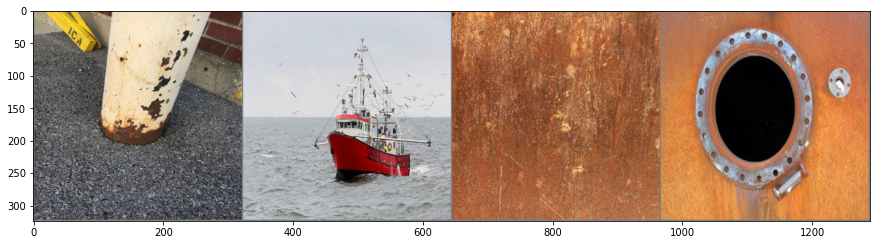

GroundTruth:
Corrosion
No corrosion
Corrosion
Corrosion


In [11]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth:')
print('\n'.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [13]:
images = images.to(device)
outputs = model(images)

In [14]:
outputs

tensor([[ 3.0683, -0.8519],
        [-0.2685,  0.6419],
        [13.9454, -6.6823],
        [ 5.3556, -1.7955]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [15]:
torch.max(outputs, 1)

torch.return_types.max(
values=tensor([ 3.0683,  0.6419, 13.9454,  5.3556], device='cuda:0',
       grad_fn=<MaxBackward0>),
indices=tensor([0, 1, 0, 0], device='cuda:0'))

In [16]:
_, predicted = torch.max(outputs, 1)

print('Predicted:')
print('\n'.join(f'{classes[predicted[j]]:5s}' for j in range(batch_size)))

Predicted:
Corrosion
No corrosion
Corrosion
Corrosion


# Accuracy

In [17]:
correct = 0
total = 0

y_pred = []
y_true = []

with torch.no_grad():
    for data in testloader:
        images, labels = data

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        output = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        y_true.extend(labels.data.cpu().numpy()) # Save Truth

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {len(testloader)*batch_size} test images: {100 * correct // total} %')

Accuracy of the network on the 60 test images: 80 %


# Confusion Matrix

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])

df_cm

,Corrosion,No corrosion
Corrosion,37,8
No corrosion,4,11


# ResNet - Residual Network

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

In [ ]:
model2 = resnet50(weights=ResNet50_Weights.DEFAULT).to(device)
model2.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 